# Fitting multiple conditions using PEtab format 

In this example, we are going to perform the parameter inference using the FitMultiCell pipeline using a cell motility model. This example has two experimental conditions which will be defined using the PEtab format. 

## Run the first condition without PEtab

First, lets try to only consider the first condition.

In [1]:
import petab_MS
from fitmulticell.PEtab.base import PetabImporter
from fitmulticell.model import MorpheusModel as morpheus_model
from fitmulticell.model import MorpheusModels as morpheus_models
from fitmulticell.sumstat import SummaryStatistics
from pyabc.sampler import RedisEvalParallelSampler
from pyabc.sampler import MulticoreEvalParallelSampler
from pyabc import QuantileEpsilon
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import pyabc
import matplotlib.pylab as plt
from pathlib import Path
import os
import scipy
import tempfile


Next, we will define the xpath for each parameters and its groud truth value.

In [2]:
par_map = {'move.duration.median': './CellTypes/CellType/Constant[@symbol="move.duration.median"]'}
obs_pars = {'move.duration.median': 150.0}

Then, we will define the attributes for our first condition.

In [3]:
condition1_external_file = str((Path(os.getcwd())) / 'PEtab_problem_2' / 'env_noise_0_900a.tif')

exp_cond_map = {'condition1': {'./Global/Field/TIFFReader': ['filename', condition1_external_file]}}



Next, we define the ground truth value for each parameter which we will tue to generate the senthitic data.

In [4]:
obs_pars_log = {key: math.log10(val) for key, val in obs_pars.items()}


Next, we will import the senthitic data and give the path to Morpheus model.

In [5]:
obs_pars_log = {key: math.log10(val) for key, val in obs_pars.items()}
condition1_obs = str((Path(os.getcwd())) / 'PEtab_problem_2' / 'center.x_end_900a.csv')


model_file = str((Path(os.getcwd())) / 'PEtab_problem_2' / 'cell_motility_model.xml')

In [6]:
data1 = pd.read_csv(condition1_obs, sep='\t')
dict_data1 = {}
for col in data1.columns:
    dict_data1[col] = data1[col].to_numpy()

Then, we will define the `summary_statistics` and `model` object as follow: 

In [7]:
sumstat = SummaryStatistics(output_file="logger_2.csv", ignore=["time", "cell.id", ])

then, we will construct Morpheus model.

In [8]:
model_cond1 = morpheus_model(
    model_file, par_map=par_map, clean_simulation=True,
    par_scale="lin", timeout=150, exp_cond_map=exp_cond_map,
    show_stdout=False, show_stderr=False,
    raise_on_error=False,
    executable="/home/emad/morpheus-2.2.5",
    sumstat=sumstat)


Now, lets run the model and check the model's output

In [9]:
condition1_tryjectory = model_cond1.sample(obs_pars_log)

(array([2., 1., 4., 2., 2., 2., 2., 1., 0., 4.]),
 array([30.32  , 33.6495, 36.979 , 40.3085, 43.638 , 46.9675, 50.297 ,
        53.6265, 56.956 , 60.2855, 63.615 ]),
 <BarContainer object of 10 artists>)

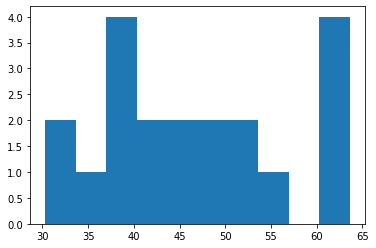

In [10]:
plt.hist(condition1_tryjectory["condition1__cell.center.x"], bins=10)

Then, we will further define the parameters space 

In [11]:
limits = {key: (0,3) for
          key, val in obs_pars.items()}


In [12]:
model_cond1.par_scale="log10"

In [13]:
prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                              for key, (lb, ub) in limits.items()})

Now, we will define our objective function:

In [14]:
def eucl_dist(sim, obs):

    if sim == -15:
        ks = np.inf
    else:
        for (k1,v1), (k2,v2) in zip(sim.items(), obs.items()):
            if k1 == "loc":
                continue
            else:
                ks, p_val = scipy.stats.ks_2samp(sim[k1], obs[k2])
    return ks


Now, we are ready to start the fitting.

In [15]:
abc = pyabc.ABCSMC(model_cond1, prior, eucl_dist, population_size=25)

ABC.Sampler INFO: Parallelize sampling on 12 processes.


In [16]:
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "cell_movement_cond1.db")

history_cond1 = abc.new(db_path, dict_data1)
history_cond1 = abc.run(max_nr_populations=10, minimum_epsilon=0.2)


ABC.History INFO: Start <ABCSMC id=4, start_time=2022-01-20 14:45:34>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.00000000e+00.
ABC INFO: Accepted: 25 / 36 = 6.9444e-01, ESS: 2.5000e+01.
ABC INFO: t: 1, eps: 9.90000000e-01.
ABC INFO: Accepted: 25 / 63 = 3.9683e-01, ESS: 2.4400e+01.
ABC INFO: t: 2, eps: 5.66210789e-01.
ABC INFO: Accepted: 25 / 71 = 3.5211e-01, ESS: 2.4338e+01.
ABC INFO: t: 3, eps: 3.20000000e-01.
ABC INFO: Accepted: 25 / 68 = 3.6765e-01, ESS: 2.2515e+01.
ABC INFO: t: 4, eps: 2.50000000e-01.
ABC INFO: Accepted: 25 / 104 = 2.4038e-01, ESS: 1.9887e+01.
ABC INFO: t: 5, eps: 2.20000000e-01.
ABC INFO: Accepted: 25 / 211 = 1.1848e-01, ESS: 2.3234e+01.
ABC INFO: t: 6, eps: 2.06597276e-01.
ABC INFO: Accepted: 25 / 204 = 1.2255e-01, ESS: 2.3156e+01.
ABC INFO: t: 7, eps: 1.90000000e-01.
ABC INFO: Accepted: 25 / 302 = 8.2781e-02, ESS: 1.7138e+01.
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=4, duration=1:20:11.054993, end_time=2022-01-20 16:05:

Let us plot some diagnostic plot for the fit.

In [17]:
pyabc.visualization.plot_epsilons(history_cond1)

<AxesSubplot:title={'center':'Epsilon values'}, xlabel='Population index', ylabel='Epsilon'>

In [18]:
from pyabc.visualization import plot_kde_1d
fig, ax = plt.subplots()

for t in range(history_cond1.max_t+1):
    particles = history_cond1.get_distribution(m=0, t=t)
    plot_kde_1d(*particles, "move.duration.median",
                label="t={}".format(t), ax=ax,
                xmin=0, xmax=10, numx=300)
ax.axvline(math.log10(150), color="k", linestyle="dashed");


## Run the second condition without PEtab

Now, we will do the same, but this time only for the second condition.

In [19]:
condition2_external_file = str((Path(os.getcwd())) / 'PEtab_problem_2' / 'env_noise_0_900b.tif')

exp_cond_map = {'condition2': {'./Global/Field/TIFFReader': ['filename', condition2_external_file]}}
condition2_obs = str((Path(os.getcwd())) / 'PEtab_problem_2' / 'center.x_end_900b.csv')


In [20]:
data2 = pd.read_csv(condition2_obs, sep='\t')
dict_data2 = {}
for col in data2.columns:
    dict_data2[col] = data2[col].to_numpy()

In [21]:
sumstat = SummaryStatistics(output_file="logger_2.csv", ignore=["time", "cell.id", ])

model_cond2 = morpheus_model(
    model_file, par_map=par_map, clean_simulation=True,
    par_scale="lin", timeout=150, exp_cond_map=exp_cond_map,
    show_stdout=False, show_stderr=False,
    raise_on_error=False,
    executable="/home/emad/morpheus-2.2.5",
    sumstat=sumstat)


In [22]:
condition2_tryjectory = model_cond2.sample(obs_pars_log)

(array([4., 1., 0., 2., 3., 3., 1., 1., 2., 3.]),
 array([28.755 , 31.8215, 34.888 , 37.9545, 41.021 , 44.0875, 47.154 ,
        50.2205, 53.287 , 56.3535, 59.42  ]),
 <BarContainer object of 10 artists>)

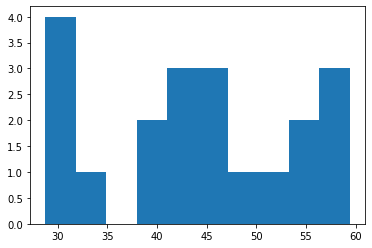

In [23]:
plt.hist(condition2_tryjectory["condition2__cell.center.x"], bins=10)

Now that we have define the model for the second condition, lets repeat the fitting process for the selected parameter

In [24]:
abc = pyabc.ABCSMC(model_cond2, prior, eucl_dist, population_size=25)

ABC.Sampler INFO: Parallelize sampling on 12 processes.


In [43]:
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "cell_movement_cond2.db")
history_cond2 = abc.new(db_path, dict_data2)
history_cond2 = abc.run(max_nr_populations=10,minimum_epsilon=0.2)


ABC.History INFO: Start <ABCSMC id=1, start_time=2022-01-20 13:41:52>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 9.80000000e-01.
ABC INFO: Accepted: 50 / 62 = 8.0645e-01, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 9.80000000e-01.
ABC INFO: Accepted: 50 / 61 = 8.1967e-01, ESS: 4.6432e+01.
ABC INFO: t: 2, eps: 9.80000000e-01.
ABC INFO: Accepted: 50 / 61 = 8.1967e-01, ESS: 4.8013e+01.
ABC INFO: t: 3, eps: 9.80000000e-01.
ABC INFO: Accepted: 50 / 61 = 8.1967e-01, ESS: 4.4342e+01.
ABC INFO: t: 4, eps: 9.80000000e-01.
Process Process-173:
Process Process-178:
Process Process-180:
Process Process-169:
Process Process-170:
Process Process-176:
Process Process-179:
Process Process-175:
Process Process-171:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
ABC.History INFO: Done <ABCSMC id=1, duration=0:17:09.294207, end_time=2022-01-20 13:59:02>
Process Process-172:
Traceback (most recent call last):
Traceback (most recent call la

  File "/home/emad/.local/lib/python3.7/site-packages/pyabc/inference_util.py", line 452, in simulate_one
    proposal_id=proposal_id,
  File "/home/emad/.local/lib/python3.7/site-packages/pyabc/model.py", line 205, in accept
    result = self.summary_statistics(t, pars, sum_stat_calculator)
  File "/home/emad/.local/lib/python3.7/site-packages/pyabc/inference_util.py", line 236, in evaluate_proposal
    t, theta_ss, summary_statistics, distance_function, eps, acceptor, x_0
  File "/home/emad/.local/lib/python3.7/site-packages/pyabc/model.py", line 205, in accept
    result = self.summary_statistics(t, pars, sum_stat_calculator)
  File "/home/emad/.local/lib/python3.7/site-packages/pyabc/model.py", line 116, in summary_statistics
    raw_data = self.sample(pars)
  File "/home/emad/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 42, in work
    new_sim = simulate_one()
  File "/home/emad/.local/lib/python3.7/site-packages/pyabc/model.py", line 11

<AxesSubplot:title={'center':'Epsilon values'}, xlabel='Population index', ylabel='Epsilon'>

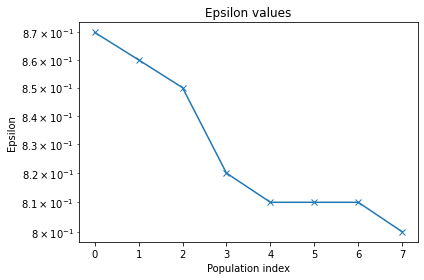

In [25]:
pyabc.visualization.plot_epsilons(history_cond2)


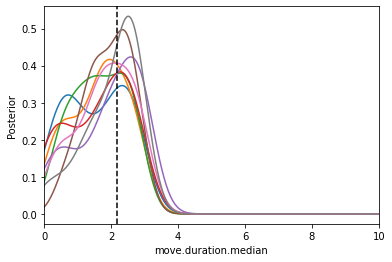

In [26]:
from pyabc.visualization import plot_kde_1d
fig, ax = plt.subplots()

for t in range(history_cond2.max_t+1):
    particles = history_cond2.get_distribution(m=0, t=t)
    plot_kde_1d(*particles, "move.duration.median",
                label="t={}".format(t), ax=ax,
                xmin=0, xmax=10, numx=300)
ax.axvline(math.log10(150), color="k", linestyle="dashed");


## Define the problem using PEtab extention

## Multiple condition 

Now, let's try some features from using the PEtab format. PEtab can facilitate the generation of multiple conditions problem. 

Wil will import a PEtab problem where we already specify more than one experimental condition.

In [2]:

mc_PEtab_problem_path = str((Path(os.getcwd())) / 'PEtab_problem_2' / 'cell_motility.yaml')
mc_PEtab_problem = petab_MS.Problem.from_yaml(mc_PEtab_problem_path)


From the PEtab problem, we will generate our priors, parameter maps, observables, parameter scale, and the measerment data.

In [3]:
mc_importer = PetabImporter(mc_PEtab_problem)
mc_PEtab_prior = mc_importer.create_prior()
mc_par_map_imported = mc_importer.get_par_map()
mc_obs_pars_imported = mc_PEtab_problem.get_x_nominal_dict(scaled=True)
mc_PEtab_par_scale = mc_PEtab_problem.get_optimization_parameter_scales()
mc_dict_data_imported = mc_PEtab_problem.get_measurement_dict()

/home/emad/Insync/blackhand.3@gmail.com/Google Drive/Bonn/Github/libpetab-python-MS/petab_MS/parameters.py:375: RuntimeWarning: divide by zero encountered in log10
  return np.log10(parameter)


Then, we will construct our two models from the PEtab problem.

In [4]:
PEtab_models = mc_importer.create_model()
sumstat = SummaryStatistics(output_file="logger_2.csv", ignore=["time", "cell.id", ])
PEtab_models.models[0].sumstat=["time","cell.id"]
PEtab_models.models[1].sumstat=["time","cell.id"]


FitMultiCell.Model INFO: Successfully loaded model
FitMultiCell.Model INFO: Successfully loaded model


In [5]:
PEtab_mc_tryjectory1 = PEtab_models.models[0].sample(mc_obs_pars_imported)
PEtab_mc_tryjectory2 = PEtab_models.models[1].sample(mc_obs_pars_imported)

Now, let's plot a single tryjectory for both conditions:

Text(0.5, 1.0, 'PEtab problem 2')

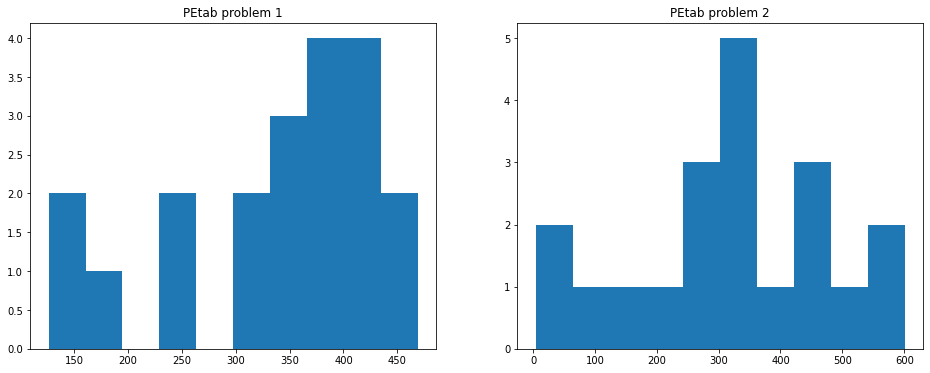

In [6]:
fig, axes = plt.subplots(1,2, figsize=(16, 6))
ax = axes[0]

ax.hist(PEtab_mc_tryjectory1["condition1__IdSumstat__cell.center.x"], bins=10)
ax.set_title("PEtab problem 1")

ax = axes[1]
ax.hist(PEtab_mc_tryjectory2["condition2__IdSumstat__cell.center.x"], bins=10)
ax.set_title("PEtab problem 2")


Now, every thing is prepared and we are ready to start the fittig.

In [10]:
abc = pyabc.ABCSMC(PEtab_models, mc_PEtab_prior, eucl_dist, population_size=50)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "PEtab_cell_movement.db")
mc_PEtab_history = abc.new(db_path, mc_dict_data_imported)
history = abc.run(max_nr_populations=8,minimum_epsilon=0.2)


ABC.Sampler INFO: Parallelize sampling on 12 processes.
ABC.History INFO: Start <ABCSMC id=9, start_time=2021-10-05 12:44:12>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 9.00000000e-01.
ABC INFO: Accepted: 50 / 106 = 4.7170e-01, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 5.40000000e-01.
ABC INFO: Accepted: 50 / 137 = 3.6496e-01, ESS: 4.7985e+01.
ABC INFO: t: 2, eps: 4.20000000e-01.
ABC INFO: Accepted: 50 / 115 = 4.3478e-01, ESS: 4.8740e+01.
ABC INFO: t: 3, eps: 3.55675552e-01.
ABC INFO: Accepted: 50 / 123 = 4.0650e-01, ESS: 4.7949e+01.
ABC INFO: t: 4, eps: 2.90000000e-01.
ABC INFO: Accepted: 50 / 270 = 1.8519e-01, ESS: 4.5600e+01.
ABC INFO: t: 5, eps: 2.70000000e-01.
ABC INFO: Accepted: 50 / 375 = 1.3333e-01, ESS: 4.7949e+01.
ABC INFO: t: 6, eps: 2.40000000e-01.
ABC INFO: Accepted: 50 / 509 = 9.8232e-02, ESS: 4.2199e+01.
ABC INFO: t: 7, eps: 2.30000000e-01.
ABC INFO: Accepted: 50 / 615 = 8.1301e-02, ESS: 4.5660e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History IN

In [11]:
pyabc.visualization.plot_epsilons(mc_PEtab_history)


<AxesSubplot:title={'center':'Epsilon values'}, xlabel='Population index', ylabel='Epsilon'>

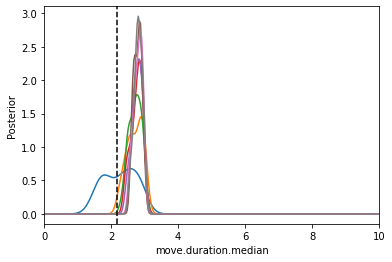

In [12]:
# df, w = history.get_distribution(t=history.max_t)
from pyabc.visualization import plot_kde_1d
fig, ax = plt.subplots()

for t in range(mc_PEtab_history.max_t+1):
    particles = mc_PEtab_history.get_distribution(m=0, t=t)
    plot_kde_1d(*particles, "move.duration.median",
                label="t={}".format(t), ax=ax,
                xmin=0, xmax=10, numx=300)
ax.axvline(math.log10(150), color="k", linestyle="dashed");
